# Importing the Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from newsapi import NewsApiClient
import re

# Collecting News Data

In [19]:
import time
from datetime import datetime, timedelta
import pandas as pd
from newsapi import NewsApiClient

# Initialize NewsAPI client
newsapi = NewsApiClient(api_key='c1591bef0539465a81e11d8932f26996')

# Function to fetch news data
def get_news_data(query, from_date, to_date):
    articles = newsapi.get_everything(q=query, from_param=from_date, to=to_date, language='en', sort_by='relevancy')
    
    # Handle missing descriptions by using empty strings
    news_data = []
    for article in articles['articles']:
        title = article['title'] if article['title'] else ''
        description = article['description'] if article['description'] else ''
        published_at = article['publishedAt']
        news_data.append((published_at, title + ' ' + description))
    
    return pd.DataFrame(news_data, columns=['Date', 'News'])

# Get the current date and the date 30 days ago
to_date = datetime.now().strftime('%Y-%m-%d')
from_date = (datetime.now() - timedelta(days=30)).strftime('%Y-%m-%d')

# Fetch news data for the last 30 days
news_df = get_news_data('JPM', from_date, to_date)

# Show the first 5 rows of the dataframe
news_df.head()

,Date,News
0,2024-10-11T11:38:00Z,Jamie Dimon says the world is 'treacherous and...
1,2024-09-25T12:50:00Z,Jamie Dimon cosigns Elon Musk's plans to slash...
2,2024-09-20T15:31:00Z,Jamie Dimon isn't making a big deal of the Fed...
3,2024-09-19T20:39:46Z,JPMorgan's junior bankers just gained an ally ...
4,2024-10-09T08:13:48Z,The big question hanging over banks as earning...


# Collecting Historical Price Data

In [20]:
import yfinance as yf
from datetime import datetime, timedelta

# Get the current date and the date 30 days ago
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=30)).strftime('%Y-%m-%d')

# Download stock data for the last 30 days
stock_data = yf.download('JPM', start=start_date, end=end_date)

# Show the first 5 rows of the stock data
stock_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-09-18,209.009995,211.339996,206.699997,207.529999,206.265991,8259900
2024-09-19,209.779999,211.910004,207.339996,210.479996,209.198029,11635200
2024-09-20,209.929993,211.419998,209.500000,211.089996,209.804306,20885000
2024-09-23,211.000000,211.800003,209.990005,211.440002,210.152191,7223500
2024-09-24,211.149994,212.949997,210.369995,211.589996,210.301270,7323200


# Finding the CAGR, Sharpe Ratio, Sortino Ratio and Maximum Dropdown

In [21]:
# 1. CAGR (Compound Annual Growth Rate)
def calculate_cagr(data):
    # Assuming data['Adj Close'] is the adjusted closing price
    data['Return'] = data['Adj Close'].pct_change()
    cumulative_return = (data['Adj Close'][-1] / data['Adj Close'][0])
    years = len(data) / 252  # Assuming 252 trading days in a year
    cagr = cumulative_return**(1/years) - 1
    return cagr

# 2. Sharpe Ratio
def calculate_sharpe_ratio(data, risk_free_rate=0.02):
    data['Return'] = data['Adj Close'].pct_change()
    excess_return = data['Return'].mean() - risk_free_rate/252
    sharpe_ratio = excess_return / data['Return'].std() * np.sqrt(252)
    return sharpe_ratio

# 3. Sortino Ratio
def calculate_sortino_ratio(data, risk_free_rate=0.02):
    data['Return'] = data['Adj Close'].pct_change()
    negative_return = data[data['Return'] < 0]['Return']
    excess_return = data['Return'].mean() - risk_free_rate / 252
    sortino_ratio = excess_return / negative_return.std() * np.sqrt(252)
    return sortino_ratio

# 4. Maximum Drawdown
def calculate_max_drawdown(data):
    data['Cumulative Return'] = (1 + data['Adj Close'].pct_change()).cumprod()
    data['Cumulative Max'] = data['Cumulative Return'].cummax()
    data['Drawdown'] = data['Cumulative Return'] / data['Cumulative Max'] - 1
    max_drawdown = data['Drawdown'].min()
    return max_drawdown

# Calculate the metrics
cagr = calculate_cagr(stock_data)
sharpe_ratio = calculate_sharpe_ratio(stock_data)
sortino_ratio = calculate_sortino_ratio(stock_data)
max_drawdown = calculate_max_drawdown(stock_data)

# Print the results
print(f"CAGR: {cagr:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")


CAGR: 162.80%
Sharpe Ratio: 4.63
Sortino Ratio: 10.89
Max Drawdown: -3.01%


# Cleaning the news data

In [22]:
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Preprocess the news data (clean text)
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove numbers
    text = text.lower().strip()          # Convert to lowercase
    return text

news_df['News'] = news_df['News'].apply(preprocess_text)

# Check if 'Date' column exists, and drop it if necessary
if 'Date' in stock_data.columns:
    stock_data = stock_data.drop(columns=['Date'])

# Merging the news data with the historical price data

In [23]:
# Reset the index of stock_data to make 'Date' a column
stock_data = stock_data.reset_index()

# Convert the 'Date' column in both DataFrames to the same format
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date
news_df['Date'] = pd.to_datetime(news_df['Date']).dt.date

# Merge the two DataFrames on the 'Date' column
merged_df = pd.merge(news_df, stock_data, on='Date', how='inner')

# Preview the merged DataFrame
merged_df.head()

,Date,News,Open,High,Low,Close,Adj Close,Volume,Return,Cumulative Return,Cumulative Max,Drawdown
0,2024-10-11,jamie dimon says the world is treacherous and ...,215.669998,224.630005,215.160004,222.289993,222.289993,18320700,0.0444,1.077686,1.077686,0.0
1,2024-10-11,elon musks tesla is a victim of its own hype f...,215.669998,224.630005,215.160004,222.289993,222.289993,18320700,0.0444,1.077686,1.077686,0.0
2,2024-10-11,lower interest rates are going to change the g...,215.669998,224.630005,215.160004,222.289993,222.289993,18320700,0.0444,1.077686,1.077686,0.0
3,2024-10-11,stock market today dow sp nasdaq waver amid b...,215.669998,224.630005,215.160004,222.289993,222.289993,18320700,0.0444,1.077686,1.077686,0.0
4,2024-10-11,things to know before the stock market opens j...,215.669998,224.630005,215.160004,222.289993,222.289993,18320700,0.0444,1.077686,1.077686,0.0


# Performing VADER Sentiment Analysis 

In [24]:
analyzer = SentimentIntensityAnalyzer()

# Analyze sentiment for each news article
def get_sentiment_score(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']

# Apply sentiment analysis on each news article
merged_df['sentiment_score'] = merged_df['News'].apply(get_sentiment_score)

# Preview the data
merged_df[['Date', 'News', 'Close', 'sentiment_score']].head()

,Date,News,Close,sentiment_score
0,2024-10-11,jamie dimon says the world is treacherous and ...,222.289993,-0.4767
1,2024-10-11,elon musks tesla is a victim of its own hype f...,222.289993,0.7839
2,2024-10-11,lower interest rates are going to change the g...,222.289993,0.8024
3,2024-10-11,stock market today dow sp nasdaq waver amid b...,222.289993,0.7506
4,2024-10-11,things to know before the stock market opens j...,222.289993,0.2960


# Setting a signal for buying or selling 

In [25]:
# Function to classify sentiment and provide buy/hold/sell signals
def classify_sentiment_and_signal(sentiment_score):
    if sentiment_score > 0.5:
        return 'Positive', 1  # 1 for "Buy"
    elif sentiment_score < 0:
        return 'Negative', -1  # -1 for "Sell"
    else:
        return 'Neutral', 0  # 0 for "Hold"

# Apply the classification and signal to the DataFrame
merged_df['Sentiment_Label'], merged_df['Signal'] = zip(*merged_df['sentiment_score'].apply(classify_sentiment_and_signal))

# Display the DataFrame with updated sentiment labels and signals
new_df = merged_df[['Date', 'News', 'sentiment_score', 'Sentiment_Label', 'Signal']]

# Show the first few rows to inspect the results
new_df.head()

,Date,News,sentiment_score,Sentiment_Label,Signal
0,2024-10-11,jamie dimon says the world is treacherous and ...,-0.4767,Negative,-1
1,2024-10-11,elon musks tesla is a victim of its own hype f...,0.7839,Positive,1
2,2024-10-11,lower interest rates are going to change the g...,0.8024,Positive,1
3,2024-10-11,stock market today dow sp nasdaq waver amid b...,0.7506,Positive,1
4,2024-10-11,things to know before the stock market opens j...,0.2960,Neutral,0


# Based on the historical data, the number of positives or negatives are checked whether buying or selling is valid

In [26]:
# Function to classify overall sentiment and determine Buy/Hold/Sell decision
def calculate_final_decision(merged_df):
    # Count total signals in the dataframe
    positive_count = (merged_df['Signal'] == 1).sum()  # Buy signals (Positive)
    neutral_count = (merged_df['Sentiment_Label'] == 'Neutral').sum()  # Neutral signals
    negative_count = (merged_df['Signal'] == -1).sum()  # Sell signals (Negative)
    
    # Display the counts
    print(f"Total Positive (Buy): {positive_count}")
    print(f"Total Neutral (Hold): {neutral_count}")
    print(f"Total Negative (Sell): {negative_count}")
    
    # Determine the final decision based on the counts
    if positive_count > neutral_count and positive_count > negative_count:
        return "Buy"
    elif neutral_count > positive_count and neutral_count > negative_count:
        return "Hold"
    else:
        return "Sell"

# Example Usage: Calculate the final decision
final_decision = calculate_final_decision(merged_df)

# Display the final decision
print(f"Final Decision: {final_decision}")

Total Positive (Buy): 38
Total Neutral (Hold): 37
Total Negative (Sell): 19
Final Decision: Buy


# Changing the data to fit a ML model

In [27]:
merged_df = merged_df.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume'])

# Assuming 'Price' is a column in your DataFrame
merged_df['Price_MA'] = merged_df['Close'].rolling(window=5).mean()  # 5-day moving average for example

# Now you can proceed with calculating Price_Change
merged_df['Price_Change'] = merged_df['Price_MA'].pct_change() * 100  # Percent change in price

# Feature Engineering: Moving Averages for Sentiment
merged_df['Sentiment_MA_5'] = merged_df['sentiment_score'].rolling(window=5).mean()
merged_df['Sentiment_MA_10'] = merged_df['sentiment_score'].rolling(window=10).mean()

# Fill missing values after calculating moving averages
merged_df.fillna(0, inplace=True)

In [28]:
merged_df.head()

,Date,News,Close,Return,Cumulative Return,Cumulative Max,Drawdown,sentiment_score,Sentiment_Label,Signal,Price_MA,Price_Change,Sentiment_MA_5,Sentiment_MA_10
0,2024-10-11,jamie dimon says the world is treacherous and ...,222.289993,0.0444,1.077686,1.077686,0.0,-0.4767,Negative,-1,0.000000,0.0,0.00000,0.0
1,2024-10-11,elon musks tesla is a victim of its own hype f...,222.289993,0.0444,1.077686,1.077686,0.0,0.7839,Positive,1,0.000000,0.0,0.00000,0.0
2,2024-10-11,lower interest rates are going to change the g...,222.289993,0.0444,1.077686,1.077686,0.0,0.8024,Positive,1,0.000000,0.0,0.00000,0.0
3,2024-10-11,stock market today dow sp nasdaq waver amid b...,222.289993,0.0444,1.077686,1.077686,0.0,0.7506,Positive,1,0.000000,0.0,0.00000,0.0
4,2024-10-11,things to know before the stock market opens j...,222.289993,0.0444,1.077686,1.077686,0.0,0.2960,Neutral,0,222.289993,0.0,0.43124,0.0


# Model Building and Fitting

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# Define features (X) and target (y)
X = merged_df[['sentiment_score', 'Price_Change', 'Sentiment_MA_5', 'Sentiment_MA_10']]  # Feature set
y = merged_df['Signal']  # Target variable (Buy = 1, Hold = 0, Sell = -1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
# Train and evaluate the regularized Random Forest model
regularized_model = RandomForestClassifier(n_estimators=100, 
                                           max_depth=10,  # Regularization parameter
                                           min_samples_split=5, 
                                           min_samples_leaf=2, 
                                           random_state=42)
regularized_model.fit(X_train, y_train)

# Make predictions with the regularized model
y_pred_reg = regularized_model.predict(X_test)

# Evaluation metrics

In [32]:
# Evaluate the regularized model
print("Regularized Random Forest Model")
print("Accuracy on test set:", accuracy_score(y_test, y_pred_reg))
print("Classification Report:")
print(classification_report(y_test, y_pred_reg, zero_division=1)) 
print("Confusion Matrix:")
cm_reg = confusion_matrix(y_test, y_pred_reg)
print(cm_reg)

Regularized Random Forest Model
Accuracy on test set: 1.0
Classification Report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00         6
           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        14

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29

Confusion Matrix:
[[ 6  0  0]
 [ 0  9  0]
 [ 0  0 14]]


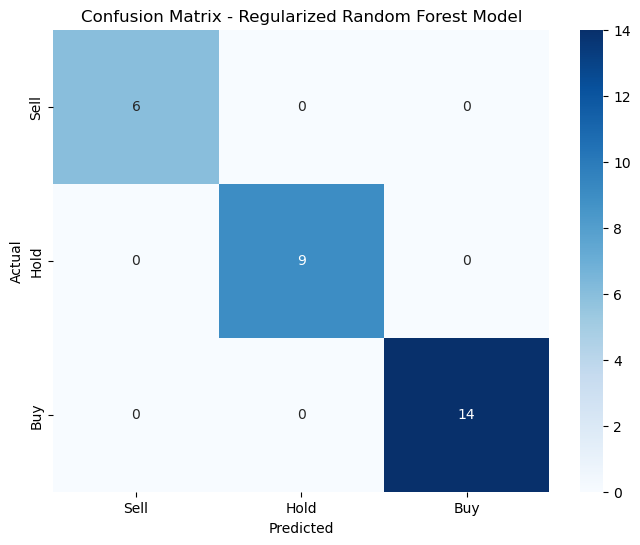

In [33]:
# Plot confusion matrix for the regularized model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_reg, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sell', 'Hold', 'Buy'], 
            yticklabels=['Sell', 'Hold', 'Buy'])

plt.title('Confusion Matrix - Regularized Random Forest Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Predictions

In [34]:
# Make final predictions with the best performing model
final_predictions = regularized_model.predict(X_test)
print("Final Predictions using the best performing model:")
print(final_predictions)

Final Predictions using the best performing model:
[-1  0  0  1 -1  0  1  0  1  1 -1  0  1 -1  0  0  1  1  1  0  1  1  1  1
 -1  1 -1  0  1]


# Final decision

In [35]:
# Aggregate predictions to decide final action
def calculate_final_decision(predictions):
    # Count occurrences of each class
    counts = pd.Series(predictions).value_counts()
    most_common = counts.idxmax()  # Get the most frequent class
    return most_common

# Define a mapping from numerical signals to actions
def map_signal_to_action(signal):
    if signal == 1:
        return "Buy"
    elif signal == -1:
        return "Sell"
    elif signal == 0:
        return "Hold"
    else:
        return "Unknown"

# Calculate the final decision
final_decision = calculate_final_decision(final_predictions)

# Map the final decision to the corresponding action
final_action = map_signal_to_action(final_decision)

print(f"Final Decision (Numerical): {final_decision}")
print(f"Final Action: {final_action}")

Final Decision (Numerical): 1
Final Action: Buy
